In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



In [ ]:
df = pd.read_csv("/content/Train.csv")

In [ ]:
features = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']
df.dropna(subset=features, inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
# Selecting the specified features: PM2.5, TEMP, NO2, SO2, DEWP, O3, WSPM, RAIN
# Adjust the column indices according to your DataFrame structure
features_columns = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']  # Use the actual column names from your DataFrame

# Select all rows for these features
training_set = df[features_columns].values

# Check the length of the training_set
length_of_training_set = len(training_set)
print(length_of_training_set)


25977


In [ ]:
training_set = training_set[-5000:]

**Feature Scaling**

In [ ]:
# normalize your data for RNN
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour
n_obs = 5000  # Adjust this if needed based on your dataset size after preprocessing
features = 8  # Total number of features included

X_train = []
y_train = []

# Ensure you're selecting all features for X_train and only the PM2.5 values for y_train
for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, :])  # Include all features in the lagged window
    y_train.append(training_set_scaled[i, 0])  # Assuming PM2.5 is the first feature for prediction

# Convert lists to numpy arrays for training the RNN
X_train, y_train = np.array(X_train), np.array(y_train)

# Now, X_train should have the shape [samples, timesteps, features]
print(X_train.shape)  # Expected shape: (number of samples, lag, features)



(4952, 48, 8)


In [ ]:
X_train.shape

(4952, 48, 8)

# **RNN**

without tuning hyperparameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Adding the first SimpleRNN layer with 200 units
model.add(SimpleRNN(units=200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding a second SimpleRNN layer with 100 units
model.add(SimpleRNN(units=100, return_sequences=True))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the third SimpleRNN layer with 50 units, return_sequences=True allows stacking another RNN layer
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the last SimpleRNN layer with 50 units
model.add(SimpleRNN(units=50))  # This is the last RNN layer, so return_sequences is not needed
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the output layer
model.add(Dense(units=1))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 48, 200)           41800     
                                                                 
 dropout (Dropout)           (None, 48, 200)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 48, 100)           30100     
                                                                 
 dropout_1 (Dropout)         (None, 48, 100)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 48, 50)            7550      
                                                                 
 dropout_2 (Dropout)         (None, 48, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

Fitting the RNN to the Training set

In [ ]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
155/155 [==============================] - 19s 93ms/step - loss: 0.1994
Epoch 2/50
155/155 [==============================] - 14s 89ms/step - loss: 0.1022
Epoch 3/50
155/155 [==============================] - 15s 97ms/step - loss: 0.0668
Epoch 4/50
155/155 [==============================] - 14s 87ms/step - loss: 0.0420
Epoch 5/50
155/155 [==============================] - 14s 87ms/step - loss: 0.0280
Epoch 6/50
155/155 [==============================] - 13s 87ms/step - loss: 0.0187
Epoch 7/50
155/155 [==============================] - 13s 87ms/step - loss: 0.0140
Epoch 8/50
155/155 [==============================] - 14s 88ms/step - loss: 0.0110
Epoch 9/50
155/155 [==============================] - 15s 99ms/step - loss: 0.0086
Epoch 10/50
155/155 [==============================] - 14s 89ms/step - loss: 0.0074
Epoch 11/50
155/155 [==============================] - 14s 91ms/step - loss: 0.0062
Epoch 12/50
155/155 [==============================] - 14s 89ms/step - loss: 0.0055
E

Making the predictions and visualising the results

In [ ]:
# Assuming 'sc' is your MinMaxScaler fitted on the training data
# And 'dataset_test' is your raw test dataset loaded from '/content/Test.csv'

# Load the test dataset (already done)
dataset_test = pd.read_csv('/content/Test.csv')

# Drop rows with NaN values in any of the columns you're using
dataset_test.dropna(subset=['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN'], inplace=True)

# Scale the test data using the same scaler as the training data
# Make sure to select the same features in the same order as the training set
test_features = dataset_test[['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']].values
test_features_scaled = sc.transform(test_features)

# Prepare sequences for testing
X_test = []
for i in range(lag, len(test_features_scaled)):
    X_test.append(test_features_scaled[i-lag:i])  # Use all features

X_test = np.array(X_test)

# Reshape X_test if necessary (it might already be in the correct shape)
# X_test should now be shaped [samples, timesteps, features]
# No need to reshape based on the previous step since it already considers all features

# Make predictions
pred_PM2 = model.predict(X_test)

# Depending on your model's output, you might need to inverse scale the predictions
# If you scaled your target variable (PM2.5) during training


207/207 [==============================] - 6s 26ms/step


In [ ]:
# Assume pred_PM2 is your predictions with shape (num_samples, 1)
# Create an array with the same number of columns as the original scaled data
pred_full = np.zeros((pred_PM2.shape[0], 8))  # 8 for the number of features you have

# Assuming PM2.5 is the first column, fill in your predictions there
pred_full[:, 0] = pred_PM2.ravel()  # Use ravel() to ensure it's a 1D array

# Perform the inverse transformation
pred_full_inverse = sc.inverse_transform(pred_full)

# Extract the PM2.5 predictions after inverse transforming
pred_PM2_inverse = pred_full_inverse[:, 0]



In [ ]:
# Assuming dataset_test is your test DataFrame and it's already preprocessed to drop NaNs as before
real_PM2 = dataset_test['PM2.5'].values[-len(pred_PM2):]  # Make sure to align the lengths

# Ensure real_PM2 is properly shaped for comparison
# If necessary, reshape it (though it should already be a 1D array matching pred_PM2_inverse in length)
real_PM2 = real_PM2.reshape(-1, 1)  # Only needed if real_PM2 isn't already a 1D array

# Now proceed with RMSE calculation
RMSE = np.sqrt(np.mean((pred_PM2_inverse - real_PM2.ravel())**2))  # Use ravel() to ensure it's 1D for calculation
print("RMSE:", RMSE)


RMSE: 27.87453369834936


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2, pred_PM2_inverse))

# Calculate MAE
mae = mean_absolute_error(real_PM2, pred_PM2_inverse)

# Calculate MSE
mse = mean_squared_error(real_PM2, pred_PM2_inverse)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2 - pred_PM2_inverse) / real_PM2)) * 100

# Calculate R-squared
r2 = r2_score(real_PM2, pred_PM2_inverse)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 27.8745
MAE: 19.2423
MSE: 776.9896
MAPE: 351.6540%
R-squared: 0.8921


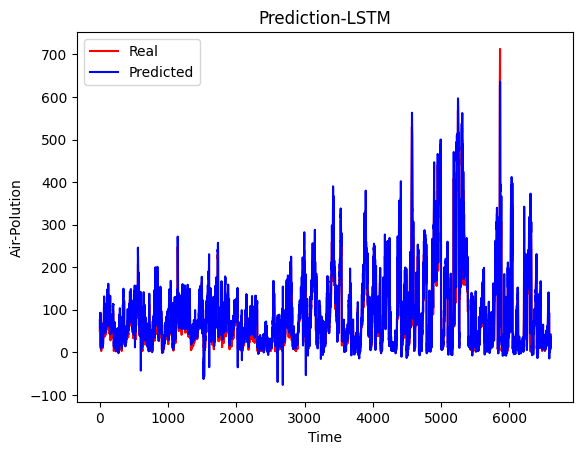

In [ ]:
plt.plot(real_PM2, color = 'red', label = 'Real')
plt.plot(pred_PM2_inverse, color = 'blue', label = 'Predicted')
plt.title('Prediction-RNN')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()

importance of parameters

In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.0 MB/s eta 0:00:00


In [ ]:
pip install --upgrade shap tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo